In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ydata_profiling as yp
from IPython.display import display
import ppscore as pps
from sklearn.ensemble import IsolationForest
%matplotlib inline

In [78]:
train = pd.read_csv('./data/realtor-data.csv')

In [3]:
report = yp.ProfileReport(train)
display(report)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [79]:
train.shape

(733159, 12)

There are 73,3159 records and 12 columns

In [80]:
train.describe()

price            bed           bath       acre_lot  \
count  7.330880e+05  617177.000000  621407.000000  572378.000000   
mean   7.257017e+05       3.422041       2.540473      19.058585   
std    1.768769e+06       2.028735       2.002442    1022.007111   
min    0.000000e+00       1.000000       1.000000       0.000000   
25%    2.375000e+05       2.000000       2.000000       0.140000   
50%    4.190000e+05       3.000000       2.000000       0.350000   
75%    7.250000e+05       4.000000       3.000000       1.380000   
max    8.750000e+08     123.000000     198.000000  100000.000000   

            zip_code    house_size  
count  732957.000000  5.207720e+05  
mean     5736.101623  2.192527e+03  
std      3764.935565  3.141461e+03  
min       601.000000  1.000000e+02  
25%      2492.000000  1.195000e+03  
50%      6001.000000  1.714000e+03  
75%      7928.000000  2.547250e+03  
max     99999.000000  1.450112e+06

# Data Cleaning Process

1. Duplicate removal
2. Missing Value Processing

In [81]:
train.duplicated().sum()

628490

In [82]:
train.drop_duplicates(inplace=True)

In [83]:
total_missing = train.isna().sum()*100/len(train)
print('Percentage Missing Value %')
total_missing

Percentage Missing Value %


status           0.000000
price            0.017197
bed             15.683727
bath            15.077052
acre_lot        25.023646
full_address     0.000000
street           0.354451
city             0.021019
state            0.000000
zip_code         0.029617
house_size      31.482101
sold_date       47.919632
dtype: float64

zip_code and city null data is 0.02%, and we can safely drop them

In [84]:
# drop na city and zipcode
train.dropna(subset=['city', 'zip_code'], inplace=True)
# drop na sold_date
train.dropna(subset=['sold_date'], inplace=True)

In [85]:
# drop na street
train.dropna(subset=['street'], inplace=True)

In [86]:
# Fill missing bed, acre_lot, bath, house_size with their mode values
train['bed'] = train['bed'].fillna(train['bed'].mode()[0])
train['bath'] = train['bath'].fillna(train['bath'].mode()[0])
train['acre_lot'] = train['acre_lot'].fillna(train['acre_lot'].mode()[0])
train['house_size'] = train['house_size'].fillna(train['house_size'].mode()[0])

In [87]:
# Changing status to boolean
train.rename(columns={'status':'for_sale'}, inplace=True)
train['for_sale'] = train['for_sale'].map(lambda x: True if x == 'for_sale' else False)

In [88]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54367 entries, 684 to 732865
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   for_sale      54367 non-null  bool   
 1   price         54367 non-null  float64
 2   bed           54367 non-null  float64
 3   bath          54367 non-null  float64
 4   acre_lot      54367 non-null  float64
 5   full_address  54367 non-null  object 
 6   street        54367 non-null  object 
 7   city          54367 non-null  object 
 8   state         54367 non-null  object 
 9   zip_code      54367 non-null  float64
 10  house_size    54367 non-null  float64
 11  sold_date     54367 non-null  object 
dtypes: bool(1), float64(6), object(5)
memory usage: 5.0+ MB


In [89]:
train.isnull().sum()

for_sale        0
price           0
bed             0
bath            0
acre_lot        0
full_address    0
street          0
city            0
state           0
zip_code        0
house_size      0
sold_date       0
dtype: int64

# Removing Outliers

<AxesSubplot:>

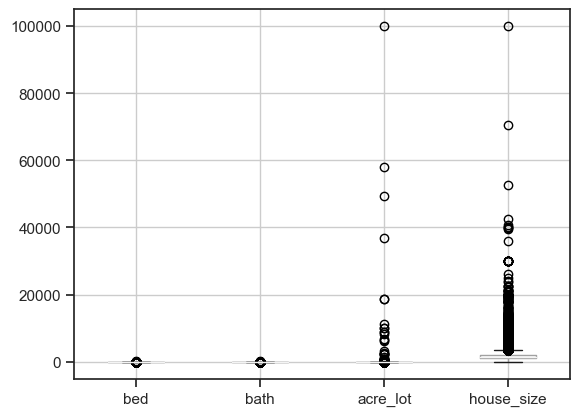

In [90]:
# boxplot of bed, bath, acre_lot, house_size
train.boxplot(column=['bed', 'bath', 'acre_lot', 'house_size'])

Removing Outliers

In [91]:
# Assuming 'train' is your DataFrame and 'bed', 'bath', 'acre_lot', 'house_size' are the column names
X = train[['bed', 'bath', 'acre_lot', 'house_size']]

# Create an Isolation Forest model
model = IsolationForest(contamination=0.05)  # Adjust contamination parameter as needed

# Fit the model to your data
model.fit(X)

# Predict outliers
outliers = model.predict(X)

# Filter the data to remove outliers
train = train[outliers == 1]

c:\Users\milan\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


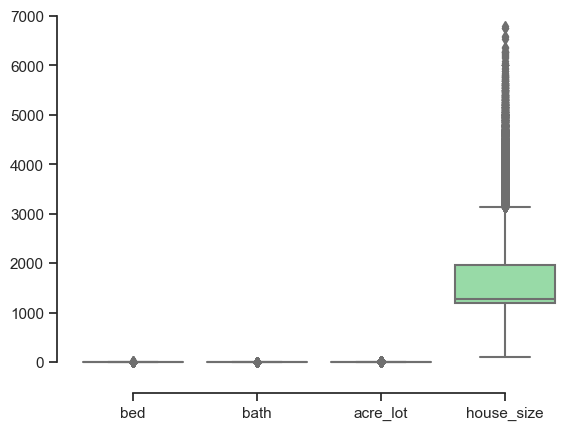

In [92]:
# boxplot of bed, bath, acre_lot, house_size
sns.set_theme(style="ticks", palette="pastel")

sns.boxplot(palette=["m", "g"],
            data=train[['bed', 'bath', 'acre_lot', 'house_size']])
sns.despine(offset=10, trim=True)

# Exploratory Data Analysis

Corelation Matrix

<AxesSubplot:>

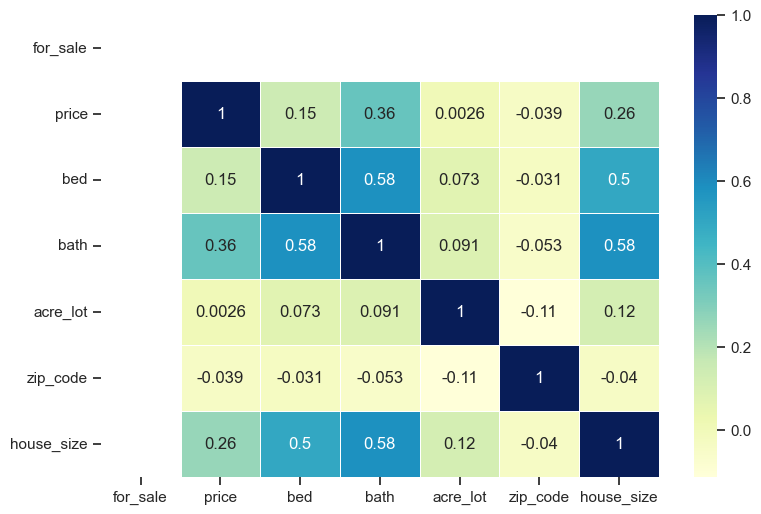

In [93]:
# Corelation Matrix

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(train.corr(), annot=True, linewidths=.5, ax=ax, cmap="YlGnBu")

Predictive Power Score

In [ ]:
pps_matrix = pps.matrix(train)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
pps_matrix = pps_matrix.apply(lambda x: round(x, 2))

<AxesSubplot:xlabel='x', ylabel='y'>

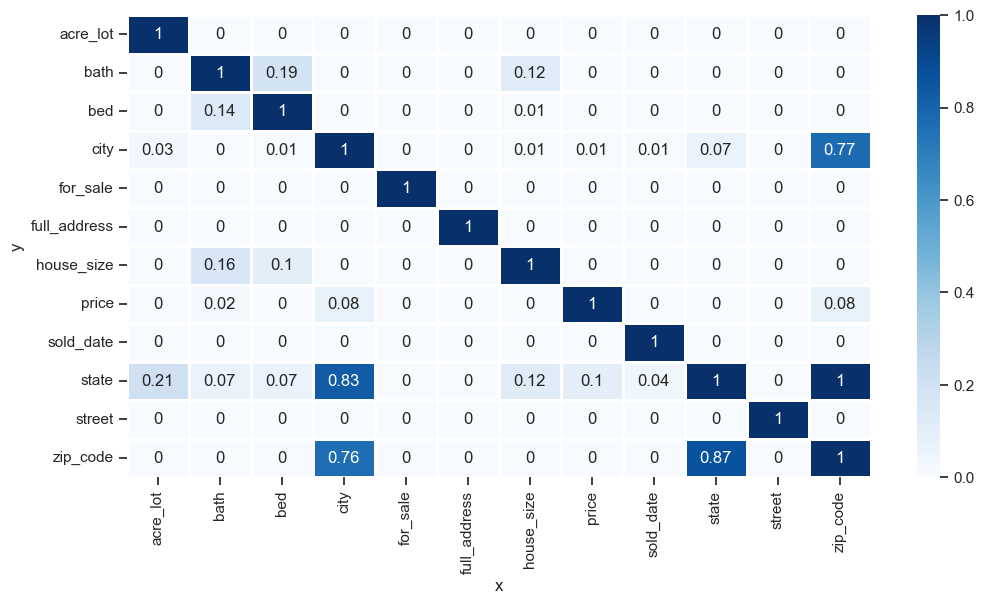

In [95]:
f, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(pps_matrix, vmin=0, vmax=1, cmap="Blues", linewidths=0.75, annot=True, ax=ax)

Corelation Matrix suggests that price is slightly correlated with bed, bath,and house_size<br/>
PPScore suggests that price is feebly correlated with bath, city and zipcode 
<hr/><hr/>

Distribution of Bed

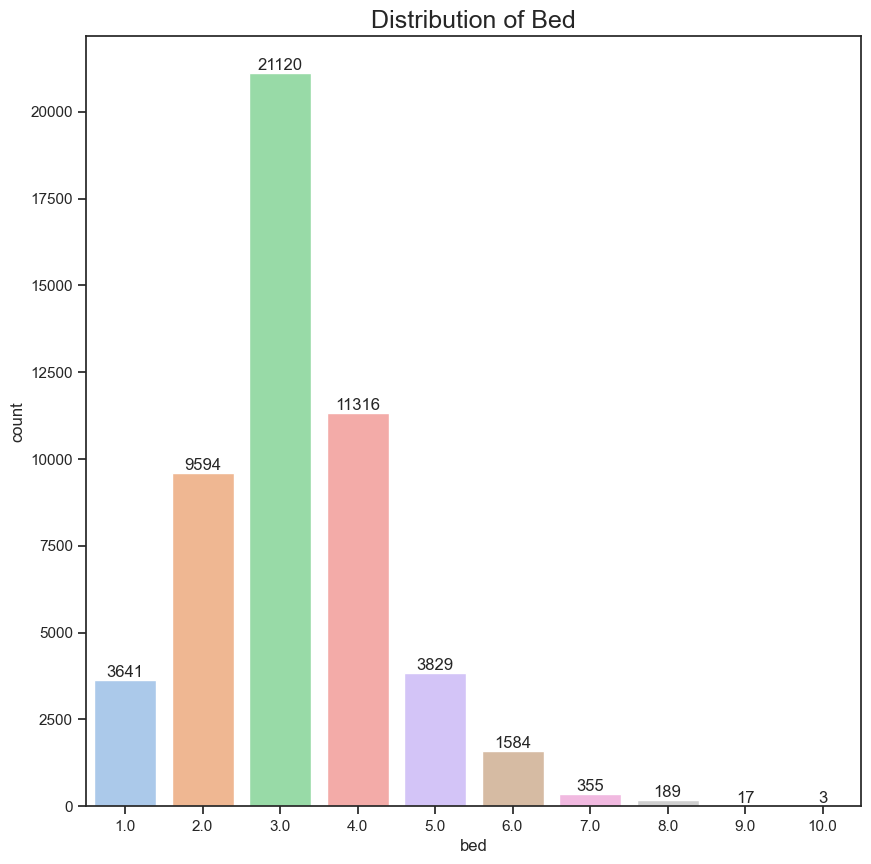

In [96]:
plt.figure(figsize=(10,10))
ax = sns.countplot(data=train, x='bed')
for i in ax.containers:
  ax.bar_label(i,)
plt.title('Distribution of Bed', fontsize=18)
plt.show()

Distribution of bath

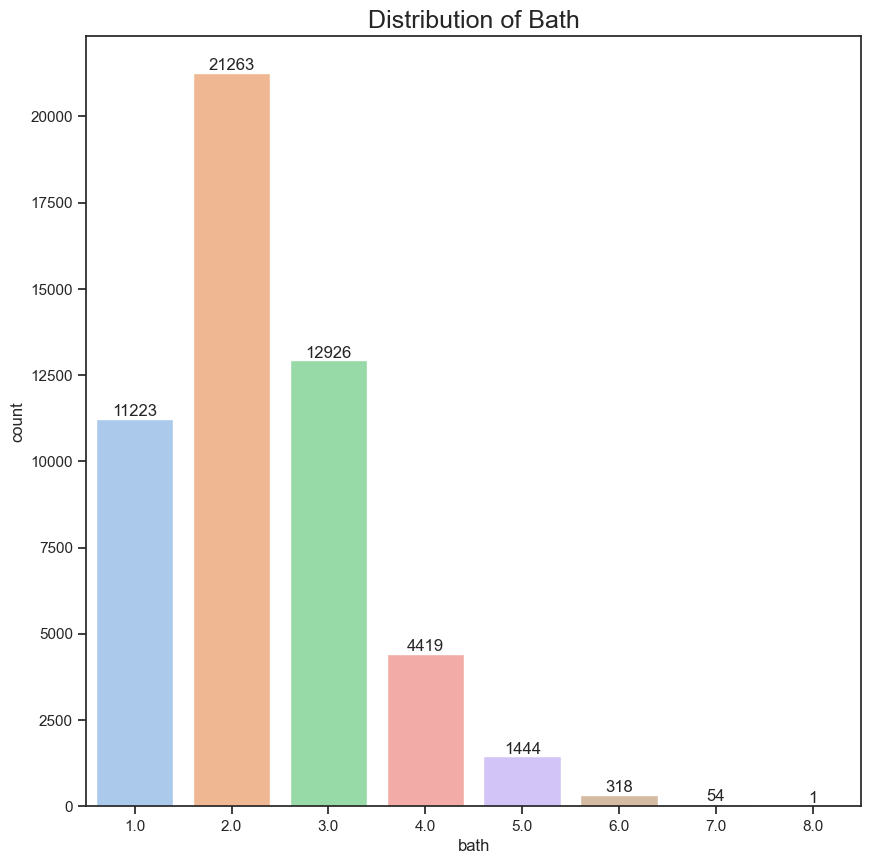

In [97]:
plt.figure(figsize=(10,10))
ax = sns.countplot(data=train, x='bath')
for i in ax.containers:
  ax.bar_label(i,)
plt.title('Distribution of Bath', fontsize=18)
plt.show()

<AxesSubplot:xlabel='bath', ylabel='bed'>

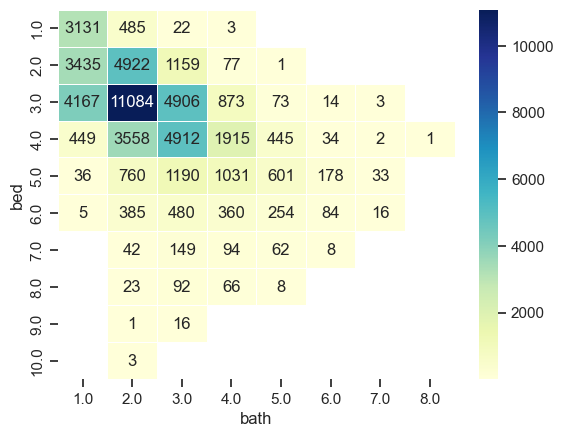

In [98]:
# heat map bed and bath
sns.set_theme(style="ticks", palette="pastel")

grouped = train.groupby(['bed', 'bath']).size().reset_index(name='count')

pivot = grouped.pivot('bed', 'bath', 'count')

sns.heatmap(pivot, annot=True, linewidths=.5, cmap="YlGnBu", fmt='g')

c:\Users\milan\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of Acre Lot')

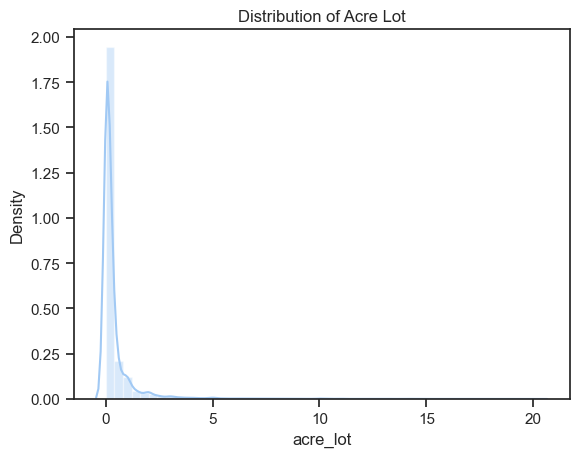

In [99]:
# Acre lot distplot
sns.distplot(train['acre_lot'])
plt.title('Distribution of Acre Lot')

Text(0.5, 0, 'Bed')

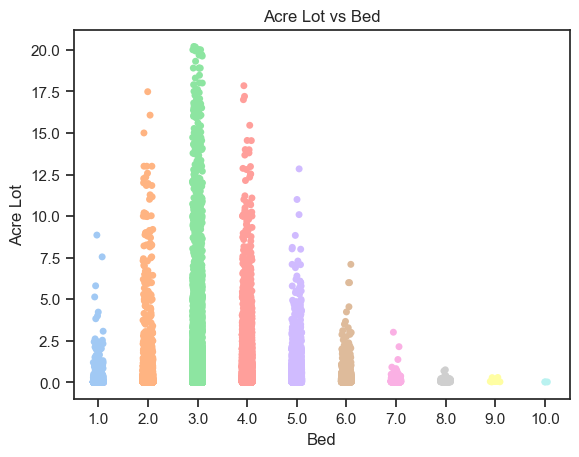

In [100]:
# acre_lot vs bed strip plot
sns.stripplot(data=train, x='bed', y='acre_lot')
plt.title('Acre Lot vs Bed')
plt.ylabel('Acre Lot')
plt.xlabel('Bed')

# Predicting House Prices

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [104]:
# standard scalar on house_size and price
scaler = StandardScaler()
df = train
df[['house_size', 'price']] = scaler.fit_transform(train[['house_size', 'price']])

In [107]:
# min max scalar
mmscaler = MinMaxScaler()

# mmscaler for bed, bath and acrelot
df[['bed', 'bath', 'acre_lot']] = mmscaler.fit_transform(df[['bed', 'bath', 'acre_lot']])

In [108]:
X = df[['bed', 'bath', 'acre_lot', 'zip_code', 'house_size', 'city', 'state']]
y = df['price']

# one-hot encode the categorical features
X = pd.get_dummies(X, columns=['city', 'state'])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

DecisionTree

In [109]:
#create the decision tree model
model_DT = DecisionTreeRegressor(max_depth=5)

# fit the model to the training data
model_DT.fit(X_train, y_train)

# make predictions on the testing data
y_pred = model_DT.predict(X_test)

# calculate
mse_DT = mean_squared_error(y_test, y_pred)
rmse_DT = mean_squared_error(y_test, y_pred, squared=False)
mae_DT = mean_absolute_error(y_test, y_pred)
r2_DT = r2_score(y_test, y_pred)

In [110]:
# Random Forest data training
model_RF = RandomForestRegressor(n_estimators=100, random_state=42)
model_RF.fit(X_train, y_train)

# data testing
y_pred = model_RF.predict(X_test)

# MSE error
mse_RF = mean_squared_error(y_test, y_pred)
rmse_RF = mean_squared_error(y_test, y_pred, squared=False)
mae_RF = mean_absolute_error(y_test, y_pred)
r2_RF = r2_score(y_test, y_pred)

In [111]:
results = {
    'Decision Tree': {'MSE': mse_DT, 'RMSE': rmse_DT, 'MAE': mae_DT, 'R^2': r2_DT},
    'Random Forest': {'MSE': mse_RF, 'RMSE': rmse_RF, 'MAE': mae_RF, 'R^2': r2_RF}
}

# konversi dictionary ke dalam dataframe
data = pd.DataFrame.from_dict(results, orient='index')
data = data.applymap(lambda x: f'{x:.2f}')
# tampilkan dataframe
print(data)

                MSE  RMSE   MAE   R^2
Decision Tree  0.54  0.73  0.32  0.47
Random Forest  0.35  0.59  0.21  0.66


In [114]:
# prediction score of each model
print(f'Random Forest: {r2_RF}')
print(f'Decision Tree: {r2_DT}')

Random Forest: 0.6580503649070077
Decision Tree: 0.4722441363852634
